In [ ]:
  !pip install scikit-multilearn

     |████████████████████████████████| 89 kB 5.5 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import re
import nltk.corpus
nltk.download('stopwords')
nltk.download('words')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords, words
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, MinMaxScaler
from skmultilearn.problem_transform import BinaryRelevance, LabelPowerset, ClassifierChain
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# Text Cleaning + Word2Vec

In [ ]:
test_label = pd.read_csv("test_labels.csv")
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")
# Merging test and train to form one huge dataset
test_data = pd.merge(test, test_label)
dataset = pd.concat([test_data, train])
dataset.drop(columns=['id'], inplace=True)
dataset.drop_duplicates(inplace=True, ignore_index=True)
dataset.drop(dataset.index[dataset['toxic'] == -1], inplace = True)
dataset.reset_index(inplace = True)
# Text cleaning
#converting to lower case
dataset['comment_text_cleaned'] = dataset['comment_text'].str.lower()
#removing special characters
dataset['comment_text_cleaned'] = dataset['comment_text_cleaned'].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", " ", str(elem)))
#removing numbers
dataset['comment_text_cleaned'] = dataset['comment_text_cleaned'].apply(lambda elem: re.sub(r"\d+", "", str(elem)))
# Removing stop words
stop = stopwords.words('english')
dataset['comment_text_cleaned'] = dataset['comment_text_cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
#Tokenizing
dataset['comment_text_cleaned'] = dataset['comment_text_cleaned'].apply(lambda x: word_tokenize(x))
#Lemmitization
def word_lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i) for i in text]
    return lem_text
dataset['comment_text_cleaned'] = dataset['comment_text_cleaned'].apply(lambda x: word_lemmatizer(x))
# Splitting into train test sets
X = dataset.drop(columns=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
y = dataset[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].copy()

X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(X,y, train_size=0.8)
X_val, X_test, y_val, y_test = train_test_split(X_test_and_val,y_test_and_val, train_size=0.5)
train_tokens = pd.Series(X_train['comment_text_cleaned']).values
w2v_model = Word2Vec(train_tokens, size= 200)
def buildWordVector(tokens, size):
  vec = np.zeros(size).reshape((1, size))
  count = 0.
  for word in tokens:
    try:
      vec += w2v_model[word].reshape((1, size))
      count += 1.
    except KeyError:
      continue
  if count != 0:
    vec /= count
  return vec

train_vecs_w2v = np.concatenate([buildWordVector(z, 200) for z in train_tokens])
# train_vecs_w2v = scaler.fit_transform(train_vecs_w2v)
train_vecs_w2v = scale(train_vecs_w2v)

val_tokens = pd.Series(X_val['comment_text_cleaned']).values
val_vecs_w2v = np.concatenate([buildWordVector(z, 200) for z in val_tokens])
# val_vecs_w2v = scaler.transform(val_vecs_w2v)
val_vecs_w2v = scale(val_vecs_w2v)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


# SVM With MultiOutputClassifier (Ran for all Multi Label Classification Techniques)

In [ ]:
from sklearn.svm import SVC
classifier = MultiOutputClassifier(SVC())
classifier.fit(train_vecs_w2v, y_train)
predictions = classifier.predict(val_vecs_w2v)
train_pred = classifier.predict(train_vecs_w2v)

# Saving the model

In [ ]:
import pickle
filename = 'SVM_model.sav'
pickle.dump(classifier, open(filename, 'wb'))

loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
def evaluation_metric(model_name, feature_extraction, y_true, y_pred):
  print('Model:', model_name)
  print('Feature extraction method:', feature_extraction)
  recall= recall_score(y_true, y_pred, average='micro')
  prec = precision_score(y_true, y_pred, average='micro')
  final_score = recall*0.6 + prec*0.4
  print('Precision: ', prec)
  print('Recall: ', recall)
  print('Final score of the model: ', final_score)
  return final_score


In [ ]:
result_test = evaluation_metric('Support Vector Machine with Multi Output Classifier', 'Word2Vec', y_val, predictions)

Model: Support Vector Machine with Multi Output Classifier
Feature extraction method: Word2Vec
Precision:  0.8462339465463381
Recall:  0.4921275736778361
Final score of the model:  0.6337701228252368


In [ ]:
result_train = evaluation_metric('Support Vector Machine with Multi Output Classifier', 'Word2Vec', y_train, train_pred)


Model: Support Vector Machine with Multi Output Classifier
Feature extraction method: Word2Vec
Precision:  0.9050850163646523
Recall:  0.573147305631382
Final score of the model:  0.7059223899246901


In [ ]:
print("Variance is: ",result_train - result_test)

Variance is:  0.07215226709945333


In [ ]:
preditions = predictions.toarray()
train_pred = train_pred.toarray()

In [ ]:
y_pred = pd.DataFrame({'toxic': predictions[:, 0], 'severe_toxic': predictions[:, 1], 'obscene': predictions[:, 2], 'threat': predictions[:, 3], 'insult': predictions[:, 4], 'identity_hate': predictions[:, 5]})
y_pred_train = pd.DataFrame({'toxic': train_pred[:, 0], 'severe_toxic': train_pred[:, 1], 'obscene': train_pred[:, 2], 'threat': train_pred[:, 3], 'insult': train_pred[:, 4], 'identity_hate': train_pred[:, 5]})

In [ ]:
def score(y_true, y_pred, label):
  prec = precision_score(y_true, y_pred)
  re = recall_score(y_true, y_pred)
  print('Results for label:', label)
  print('Precision score:', prec)
  print('Recall score:', re)
  print('Final Score:', re*0.6 + prec*0.4, '\n')
  return [re*0.6 + prec*0.4, prec, re]

# Class wise score for SVM

Model: SVM with Classifier Chains 
Feature extraction method: Word2Vec 

Results for label: toxic
Precision score: 0.8643067846607669
Recall score: 0.5438515081206496
Final Score: 0.6720336187366966 

Results for label: severe_toxic
Precision score: 0.65
Recall score: 0.06735751295336788
Final Score: 0.3004145077720207 

Results for label: obscene
Precision score: 0.8377801494130203
Recall score: 0.6607744107744108
Final Score: 0.7315767062298546 

Results for label: threat
Precision score: 1.0
Recall score: 0.05
Final Score: 0.43000000000000005 

Results for label: insult
Precision score: 0.7169373549883991
Recall score: 0.5808270676691729
Final Score: 0.6352711825968633 

Results for label: identity_hate
Precision score: 0.8363636363636363
Recall score: 0.22885572139303484
Final Score: 0.47185888738127546 



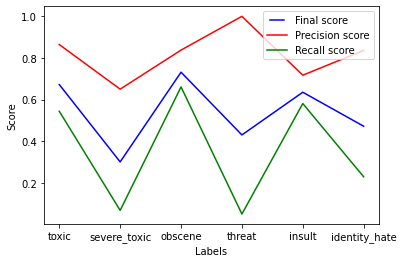

In [ ]:
print('Model: SVM with Classifier Chains \nFeature extraction method: Word2Vec')
print()
prec_score = []
re_score = []
fina_score = []
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

for label in labels:
  scores = score(y_val[label], y_pred[label], label)
  fina_score.append(scores[0])
  prec_score.append(scores[1])
  re_score.append(scores[2])

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(labels, fina_score, 'b', label='Final score')
line2, = plt.plot(labels, prec_score, 'r', label='Precision score')
line3, = plt.plot(labels, re_score, 'g', label='Recall score')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Score')
plt.xlabel('Labels')
plt.show()

Model: SVM with classifier chains 
Feature extraction method: Word2Vec 

Results for label: toxic
Precision score: 0.9097084874021842
Recall score: 0.6192706199145349
Final Score: 0.7354457669095946 

Results for label: severe_toxic
Precision score: 0.8707865168539326
Recall score: 0.09967845659163987
Final Score: 0.40812168069655697 

Results for label: obscene
Precision score: 0.886354998099582
Recall score: 0.718865598027127
Final Score: 0.785861358056109 

Results for label: threat
Precision score: 0.9411764705882353
Recall score: 0.11829944547134935
Final Score: 0.4474502555181037 

Results for label: insult
Precision score: 0.7978665207877462
Recall score: 0.6422987999559617
Final Score: 0.7045258882886756 

Results for label: identity_hate
Precision score: 0.8908145580589255
Recall score: 0.29970845481049563
Final Score: 0.5361508961098675 



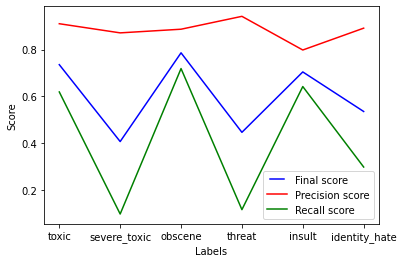

In [ ]:
print('Model: SVM with classifier chains \nFeature extraction method: Word2Vec ')
print()
prec_score = []
re_score = []
fina_score = []
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

for label in labels:
  scores = score(y_train[label], y_pred_train[label], label)
  fina_score.append(scores[0])
  prec_score.append(scores[1])
  re_score.append(scores[2])

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(labels, fina_score, 'b', label='Final score')
line2, = plt.plot(labels, prec_score, 'r', label='Precision score')
line3, = plt.plot(labels, re_score, 'g', label='Recall score')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Score')
plt.xlabel('Labels')
plt.show()

# Generating score v/s value graphs for kernel parameter of SVM (was not able to generate) 

In [ ]:
from sklearn.svm import SVC
solver = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
train_results = []
test_results = []
for estimator in solver:
   classifier = ClassifierChain(SVC(kernel = estimator))
   classifier.fit(train_vecs_w2v, y_train)
   train_pred = classifier.predict(train_vecs_w2v)
   score = evaluation_metric('Random Forest with Multi Output Classifier', 'Word2Vec', y_train, train_pred)
   train_results.append(score)

   y_pred = classifier.predict(val_vecs_w2v)
   score = evaluation_metric('Random Forest with Multi Output Classifier', 'Word2Vec', y_val, y_pred)
   test_results.append(score)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(solver, train_results, 'b', label='Train score')
line2, = plt.plot(solver, test_results, 'r', label='Test score')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Score')
plt.xlabel('kernel')
plt.show()